In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

CLASSES = {0 : 'background',
           5 : 'Mucosa',
           4 : 'Linfocitos',
           1 : 'Submucosa',
           3 : 'Muscular',
           2 : 'Subserosa',
          }
NUM_CLASSES = len(CLASSES)

TRAIN_PATH = '../DB/qupath_images/'
IMG_SIZE = 512
BATCH_SIZE = 32
SEED = 123
BACKBONE = 'resnet34'
backbone_preprocess = sm.get_preprocessing(BACKBONE)
scaler = MinMaxScaler()

2021-07-30 14:44:17.001490: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


# Load data

In [2]:
def preprocess_data(img, mask):
    global NUM_CLASSES
    #img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = backbone_preprocess(img)

    #Encode labels from 0 to NUM_CLASSES
    labelencoder = LabelEncoder()
    #Must be transformed to 1 dim array
    n, h, w, c = mask.shape
    mask = mask.reshape(-1,1)
    #transform colours into labels
    mask = labelencoder.fit_transform(mask)
    mask = mask.reshape(n, h, w)
    #Transform 1 channel label to hot encoded
    mask = tf.keras.utils.to_categorical(mask, NUM_CLASSES)

    return (img, mask)

def get_segmentation_generator(path, mode, augmentation=True, val_split=0.2):
    """
    Returns a generator for both input images and masks.
    Must have defined a preprocess_data(img, mask) function returning (img, mask)
    :param path: path to the target dir containing images and masks directories
    :mode: spicify whether is training or validation split
    :augmentation: boolean for performing data augmentation (default=True)
    :val_split: the validation split (default=0.2)
    :return: generator
    """ 
    if(augmentation):
        data_gen_args = dict(validation_split=val_split,
                             horizontal_flip=True,
                             vertical_flip=True,
                             #rotation_range=90.,
                             #width_shift_range=0.1,
                             #height_shift_range=0.1,
                             #zoom_range=0.2,
                             #shear_range=0.05,
                             #brightness_range=None,
                             fill_mode='reflect', #'constant','nearest','reflect','wrap'
                             #dtype=None,
                             #featurewise_center=True,
                             #featurewise_std_normalization=True,
                             rescale=1. / 255,  #input normalizatoin
                            ) # Mejor manera: DigitalSreeni 216 min 19
   
    else: data_gen_args = dict(validation_split=val_split,
                               rescale=1. / 255
                              )

    # same arguments in order to transform images and masks equaly
    image_datagen = ImageDataGenerator(**data_gen_args)    
    
    image_generator = image_datagen.flow_from_directory(
        directory=path+'images',
        #shuffle=True,
        subset=mode,  # train or validation
        class_mode=None,
        seed=SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    mask_generator = image_datagen.flow_from_directory(
        directory=path+'masks',
        color_mode='grayscale',
        #shuffle=True,
        subset=mode,  # train or validation
        class_mode=None,
        seed=SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    
    generator = zip(image_generator, mask_generator)
    for (img, mask) in generator:
        img, mask = preprocess_data(img, mask)
        yield (img, mask)
        
        
train_generator = get_segmentation_generator(TRAIN_PATH, mode='training', augmentation=True)
# validation data should never be augmented
val_generator = get_segmentation_generator(TRAIN_PATH, mode='validation', augmentation=False)

# Check loaded images

Found 36 images belonging to 1 classes.
Found 36 images belonging to 1 classes.


/mnt/beegfs/spack/opt/spack/linux-centos7-x86_64/gcc-4.9.4/miniconda3-4.3.30-rc2pkggawlbh6twcvefw6pwv7sgc6bc5/envs/tensorflow_2.5/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Found 9 images belonging to 1 classes.
Found 9 images belonging to 1 classes.
Images is shape (32, 512, 512, 3)
Masks is shape (32, 512, 512, 6) and has values [0. 1.]


<function matplotlib.pyplot.show(close=None, block=None)>

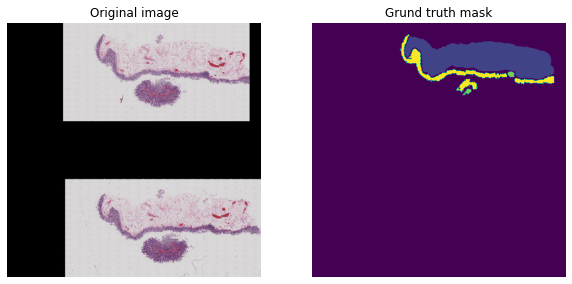

In [3]:
images, masks = train_generator.__next__()
val_images, val_masks = val_generator.__next__()

#print('Detected', len(images), 'images for training and', len(val_images), 'images for validation')
print('Images is shape', images.shape)
print('Masks is shape', masks.shape, 'and has values', np.unique(masks))

for i in range(0,1):
    f = plt.figure(figsize = (10, 10))
    image = images[i]
    mask = np.argmax(masks[i], axis=2) #hot encoded to 1 channel
    f.add_subplot(1,2,1)
    plt.axis('off')
    plt. title('Original image')
    plt.imshow(image)
    f.add_subplot(1,2,2)
    plt.axis('off')
    plt. title('Grund truth mask')
    plt.imshow(mask)
plt.show

# Get class weights

In [4]:
class_weights = [0.2138, 2.6031, 2.9286, 2.5219, 69.9673, 5.3551]

# Prepare Unet model

In [5]:
sm.set_framework('tf.keras')
sm.framework()

ACTIVATION = 'softmax'
OPTIMIZER = tf.keras.optimizers.Adam(0.0001)

dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
TOTAL_LOSS = dice_loss + (1 * focal_loss)


METRICS = metrics = [sm.metrics.IOUScore(threshold=0.5),
                     sm.metrics.FScore(threshold=0.5)]

model = sm.Unet(BACKBONE, 
                encoder_weights='imagenet',
                classes=NUM_CLASSES, 
                activation=ACTIVATION,
                #encoder_freeze=True
               )

model.compile(OPTIMIZER, 
              loss=TOTAL_LOSS,
              metrics=METRICS)
#model.summary()    #print the model structure


def show_prediction():
    global train_generator
    title = ['Input Image', 'Expected Annotation', 'Prediction'] 
    images, masks = train_generator.__next__()
    prediction = model.predict(images)
    print('Prediction has shape and values:',prediction.shape, np.unique(prediction[0]))
    
    f = plt.figure(figsize = (10, 10))
    image = images[0]
    mask = np.argmax(masks[0], axis=2) #hot encoded to 1 channel
    prediction = np.argmax(prediction[0], axis=2) #hot encoded to 1 channel
    print('Hot encoded prediction has shape and values:',prediction.shape, np.unique(prediction))
    f.add_subplot(1,3,1)
    plt.axis('off')
    plt. title('Original image')
    plt.imshow(image)
    f.add_subplot(1,3,2)
    plt.axis('off')
    plt. title('Ground truth mask')
    plt.imshow(mask)
    f.add_subplot(1,3,3)
    plt.axis('off')
    plt. title('Predicted mask')
    plt.imshow(prediction)
    plt.show(block=True)
    plt.show

# This class is used by model.fet to print a prediction at the end of every epoch
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        show_prediction()

2021-07-30 14:44:29.068983: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-30 14:44:36.394395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-30 14:44:36.394481: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-30 14:44:36.415050: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-30 14:44:36.415170: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-30 14:44:36.427062: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

# Train


Sample Prediction after epoch 50

Prediction has shape and values: (32, 512, 512, 6) [3.8331482e-20 3.9424740e-20 5.0026872e-20 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
Hot encoded prediction has shape and values: (512, 512) [0 1 3 4 5]


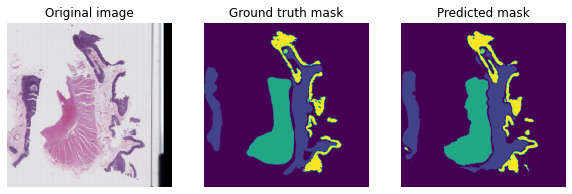

In [6]:
show_prediction()
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=50,
                    validation_data=val_generator,
                    validation_steps=50,
                    callbacks=[DisplayCallback()]
                   )

# Plot history

In [7]:
model.save('unet_first_working.hdf5')

/mnt/beegfs/spack/opt/spack/linux-centos7-x86_64/gcc-4.9.4/miniconda3-4.3.30-rc2pkggawlbh6twcvefw6pwv7sgc6bc5/envs/tensorflow_2.5/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [8]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'history_unet_50epochs.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

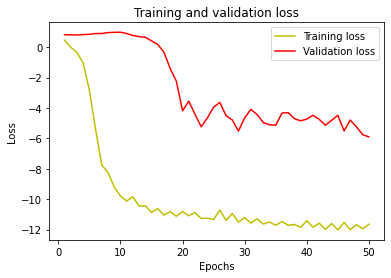

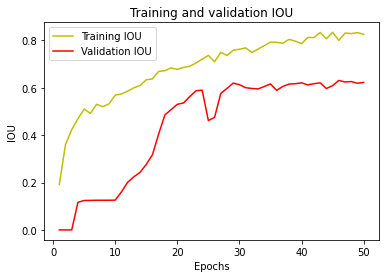

In [9]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

Mean IoU using Unet = 0.6225018
IoU for background is: 0.88536507
IoU for Submucosa is: 0.6202935
IoU for Subserosa is: 0.64352524
IoU for Muscular is: 0.7652983
IoU for Linfocitos is: 0.2872879
IoU for Mucosa is: 0.5332408


<function matplotlib.pyplot.show(close=None, block=None)>

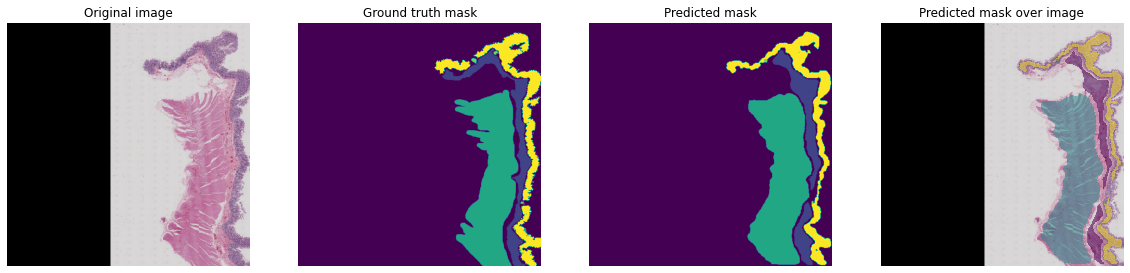

In [31]:
from keras.metrics import MeanIoU
#model = load_model('saved_models/xxxxxxxxxxxx.hdf5', compile=False)

CLASSES = {0 : 'background',
           5 : 'Mucosa',
           4 : 'Linfocitos',
           1 : 'Submucosa',
           3 : 'Muscular',
           2 : 'Subserosa',
          }

test_images, test_masks = val_generator.__next__()

test_masks = np.argmax(test_masks, axis=3) #from hot encoded to 1 channel

prediction=model.predict(test_images)
prediction=np.argmax(prediction, axis=3)

IOU = MeanIoU(num_classes=NUM_CLASSES)  
#compare groun truth and predicted masks
IOU.update_state(test_masks, prediction)

print("Mean IoU using Unet =", IOU.result().numpy())

#To calculate I0U for each class...
values = np.array(IOU.get_weights()).reshape(NUM_CLASSES, NUM_CLASSES)


class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] + values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0])
class1_IoU = values[1,1]/(values[1,0] + values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1])
class2_IoU = values[2,2]/(values[2,0] + values[2,1] + values[2,2] + values[2,3] + values[2,4] + values[2,5] + values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2])
class3_IoU = values[3,3]/(values[3,0] + values[3,1] + values[3,2] + values[3,3] + values[3,4] + values[3,5] + values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3])
class4_IoU = values[4,4]/(values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,4] + values[4,5] + values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4])
class5_IoU = values[5,5]/(values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] + values[5,5] + values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5])

print('IoU for',CLASSES[0],'is:', class0_IoU)
print('IoU for',CLASSES[1],'is:', class1_IoU)
print('IoU for',CLASSES[2],'is:', class2_IoU)
print('IoU for',CLASSES[3],'is:', class3_IoU)
print('IoU for',CLASSES[4],'is:', class4_IoU)
print('IoU for',CLASSES[5],'is:', class5_IoU)

#with np.printoptions(threshold=np.inf):
#    print(test_masks[0])

#plots
f = plt.figure(figsize = (20, 20))
f.add_subplot(1,4,1)
plt.axis('off')
plt. title('Original image')
plt.imshow(test_images[0])
f.add_subplot(1,4,2)
plt.axis('off')
plt. title('Ground truth mask')
plt.imshow(test_masks[0], cmap='viridis')
f.add_subplot(1,4,3)
plt.axis('off')
plt. title('Predicted mask')
plt.imshow(prediction[0])
f.add_subplot(1,4,4)
plt.axis('off')
plt. title('Predicted mask over image')
plt.imshow(test_images[0])
no_backgroung_prediction = np.ma.masked_where(prediction == 0, prediction) # remove background(0) from prediction
plt.imshow(no_backgroung_prediction[0], alpha=0.5)
plt.show